In [13]:
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from skimage import io

In [4]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.imported_atlas_utilities import get_all_structures
xy_ng_resolution_um = 5
color_radius = 3
animal = 'MD589'

csvfile = os.path.join(DIR, 'neuroglancer', 'contours', 'hand_annotations.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))

In [24]:
idx = 200
mask_filepath = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/masks/MD594/aligned/{}.tif'.format(idx)
mask = io.imread(mask_filepath)
mask.shape

(728, 1468)

In [6]:
structures = ['SC', 'IC']
colors = get_structure_colors()

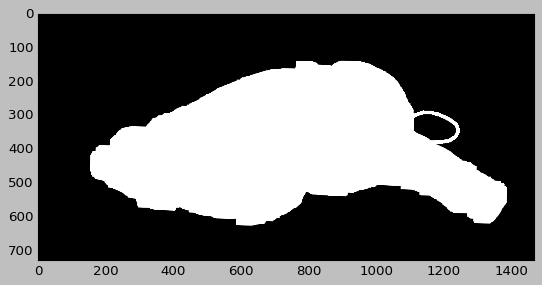

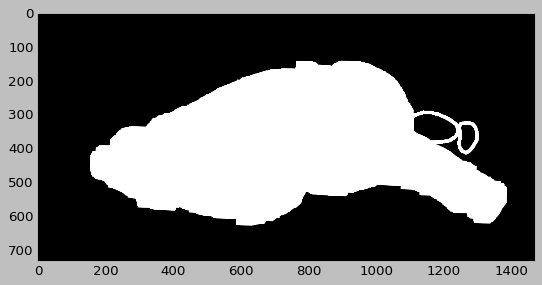

In [99]:
test_image = np.zeros(mask.shape, dtype='uint8')

for structure in structures:
    try:
        color = colors[structure.upper()]
    except:
        sided = '{}_R'.format(structure)
        color = colors[sided]
    contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, hand_annotations, densify=4)
    pts = contour_annotations[idx][structure][1]
    points = np.array(pts,dtype=np.int32)
    #continue
    points = points // 20
    cv2.polylines(mask, [points], isClosed=False, color=(255,255,255), thickness=10 )
    plt.imshow(mask, cmap="gray")
    plt.show()

In [70]:
test_image.shape

(728, 1468)

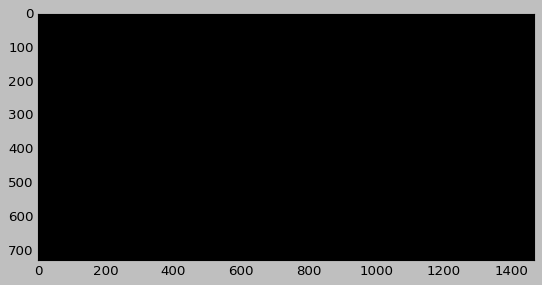

In [69]:
plt.imshow(test_image, cmap="gray")
plt.show()